<a href="https://colab.research.google.com/github/inesbsilveira/2nd-semester-2023/blob/main/IMG_SEGM_GREENHOUSES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


epoch,train_loss,valid_loss,time
0,0.749029,0.423311,00:46


epoch,train_loss,valid_loss,time
0,0.403848,0.330217,00:55
1,0.374356,0.343574,00:54


<Axes: >

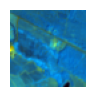

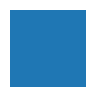

In [ ]:
from fastai.vision.all import *
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

# Define paths
path = Path('/content/drive/MyDrive/AAA')
image_folder = path/'images'
mask_folder = path/'labels1'

# Create DataBlock
def get_items(path):
    image_files = get_image_files(image_folder)
    return image_files

def get_mask_fn(image_file):
    return mask_folder / f'{image_file.stem}_mask1.png'

codes = ['object', 'background']  # Labels in the mask

dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_items,
                   get_y=get_mask_fn,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))

# Create DataLoaders
dls = dblock.dataloaders(path, bs=8)

# Define U-Net model
learn = unet_learner(dls, resnet34)

# Train the model
learn.fine_tune(10)

# Perform inference on test images
test_dl = dls.test_dl(get_image_files(image_folder))
preds = learn.get_preds(dl=test_dl)

# Display sample predictions
sample_idx = 0
sample_image_path = list(test_dl.items)[sample_idx]
sample_image = PILImage.create(sample_image_path)
sample_pred = preds[0][sample_idx].argmax(dim=0).numpy()

sample_image.show()
TensorImage(sample_pred).show(cmap='tab20')


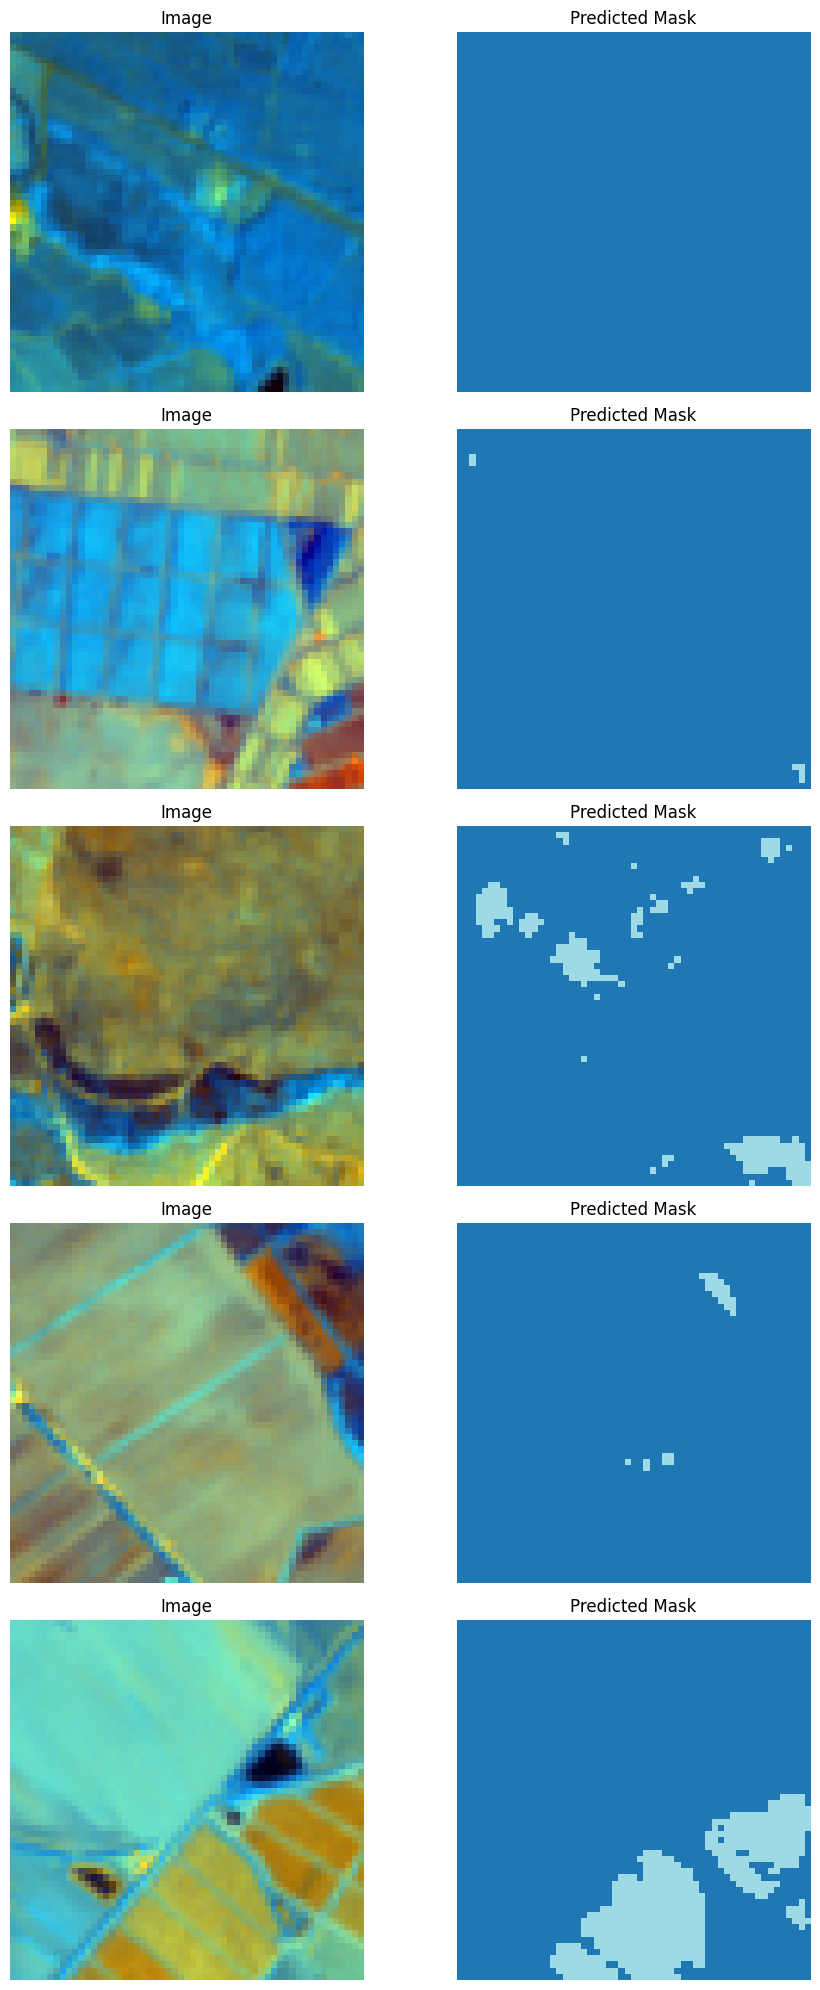

In [ ]:
# Perform inference on test images
test_dl = dls.test_dl(get_image_files(image_folder))
preds = learn.get_preds(dl=test_dl)[0]

# Display sample predictions
sample_indices = [0, 1, 2, 3, 4]

fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for i, idx in enumerate(sample_indices):
    sample_image_path = list(test_dl.items)[idx]
    sample_image = PILImage.create(sample_image_path)
    sample_pred = preds[idx].argmax(dim=0).numpy()

    axes[i, 0].imshow(sample_image)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(sample_pred, cmap='tab20')
    axes[i, 1].set_title('Predicted Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


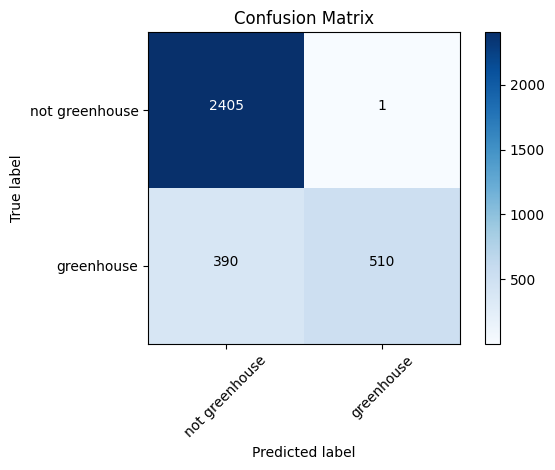

In [ ]:
# Convert predicted and ground truth labels to 1D arrays
pred_labels = sample_pred.flatten()
true_labels = np.array(Image.open(get_mask_fn(sample_image_path))).flatten()

# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
classes = ['not greenhouse', 'greenhouse']

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Fill in confusion matrix with values
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.show()


In [ ]:
# Compute confusion matrix

from sklearn.metrics import classification_report
report = classification_report(true_labels, pred_labels)
print(report)

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92      2406
         1.0       1.00      0.57      0.72       900

    accuracy                           0.88      3306
   macro avg       0.93      0.78      0.82      3306
weighted avg       0.90      0.88      0.87      3306



In [ ]:
from sklearn.metrics import roc_auc_score

# Compute the AUC score
auc_score = roc_auc_score(true_labels, pred_labels)
print("AUC:", auc_score)

AUC: 0.7831255195344972
